In [29]:
import pydataset 
import itertools
import json
import random
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
import math
import toolz
import glob
import copy
from scipy.stats import wilcoxon, norm
import plotly.express as px
import plotly.graph_objects as go
import torch
import numpy as np
import pandas as pd

In [3]:
exp1 = pd.concat([pd.read_csv('UserC1/eva_3ppl_batch_results.csv'),
                 pd.read_csv('UserC1/eva_7ppl_batch_results.csv')])
exp2 = pd.read_csv('UserC2/aturk_batch_results.csv')

In [6]:
def filterResults(df):
    df['quality'] = df.apply(lambda x: getQuality(x), axis = 1)
    return df[df.quality == True]
    
def getQuality(row):
    ans = json.loads(row['Answer.taskAnswers'])[0]
    if (ans['img10_1']['img10_1'] == ans['img1_1']['img1_1']):
        return False
    else:
        return True

def unPack(df):
    pairs = []
    answers = []
    for idx, row in df.iterrows():
        ans = json.loads(row['Answer.taskAnswers'])[0]
        for i in range(1, 9 + 1):
            key = 'img' + str(i) + '_1'
            key2 = 'img' + str(i) + '_2'
            if ans[key][key] == True:
                pairs.append([row["Input." + key], row["Input." + key2], 1])
                answers.append(1)
            else:
                pairs.append([row["Input." + key], row["Input." + key2], 2])
                answers.append(2)

    resultPair = pd.DataFrame(pairs, columns=['img1', 'img2', 'wIdx'])
    resultPair['img1Gp'] = resultPair['img1'].apply(lambda x: x.split('/')[-1].split('.')[0].split('_')[1])
    resultPair['img2Gp'] = resultPair['img2'].apply(lambda x: x.split('/')[-1].split('.')[0].split('_')[1])
    resultPair['cIdx'] = resultPair['img1'].apply(lambda x: x.split('/')[-1].split('_')[0])
    
    return resultPair

def getResult(df):
    return unPack(filterResults(df))

In [8]:
exp1Result = getResult(exp1)
exp2Result = getResult(exp2)

In [23]:
def test(resultPair, group1, group2):
    pairCount = resultPair[(resultPair.img1Gp == group1) & (resultPair.img2Gp == group2)].groupby(['cIdx', 'wIdx']).size().unstack().fillna(0)
    # pairCount.head()
    return wilcoxon(pairCount[1].values, pairCount[2].values)

In [16]:
name = ['Human', 'Excel', 'Ours', 'Random']

## 0 human; 1 excel/vega; 2 ours; 3 random

In [21]:
exp1Result.groupby(['img1Gp', 'img2Gp', 'wIdx']).size().unstack().fillna(0)

wIdx             1    2
img1Gp img2Gp          
0      1       209  192
       2       170  249
       3       261  147
1      2       156  263
       3       219  190
2      3       281  138

In [25]:
for pairs in [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]:
    i, j = pairs
    print(name[i], name[j], 'wilcoxon: ', test(exp1Result, str(i), str(j)))

Human Excel wilcoxon:  WilcoxonResult(statistic=443.0, pvalue=0.2833618437265718)
Human Ours wilcoxon:  WilcoxonResult(statistic=246.0, pvalue=0.002094986264485123)
Human Random wilcoxon:  WilcoxonResult(statistic=242.5, pvalue=0.0006423443816976878)
Excel Ours wilcoxon:  WilcoxonResult(statistic=236.0, pvalue=0.00029245208578999936)
Excel Random wilcoxon:  WilcoxonResult(statistic=379.0, pvalue=0.36254404238867344)
Ours Random wilcoxon:  WilcoxonResult(statistic=112.0, pvalue=9.728832711072748e-07)


In [26]:
exp2Result.groupby(['img1Gp', 'img2Gp', 'wIdx']).size().unstack().fillna(0)

wIdx             1    2
img1Gp img2Gp          
0      1       464  279
       2       363  383
       3       480  257
1      3       397  346
2      1       480  249
       3       488  251

In [28]:
for pairs in [[0,1],[0,2],[0,3],[1,3],[2,1],[2,3]]:
    i, j = pairs
    print(name[i], name[j], 'wilcoxon: ', test(exp2Result, str(i), str(j)))

Human Excel wilcoxon:  WilcoxonResult(statistic=360.0, pvalue=2.9495091098156303e-06)
Human Ours wilcoxon:  WilcoxonResult(statistic=1042.5, pvalue=0.544568922308388)
Human Random wilcoxon:  WilcoxonResult(statistic=345.0, pvalue=1.0631401679444258e-06)
Excel Random wilcoxon:  WilcoxonResult(statistic=1023.5, pvalue=0.2688451314616589)
Ours Excel wilcoxon:  WilcoxonResult(statistic=253.0, pvalue=3.6540081362299944e-09)
Ours Random wilcoxon:  WilcoxonResult(statistic=370.0, pvalue=1.7830226865184712e-07)


## Visualize time and edits

In [30]:
df1 = pd.read_csv(os.path.join('UserC1', 'userc1HumanResult.csv'))
df2 = pd.read_csv(os.path.join('UserC2', 'userc2HumanResult.csv'))

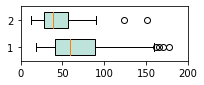

In [31]:
## Time
plt.figure(figsize=(3,1))
fig = plt.boxplot([df2.time, df1.time], widths = 0.6, patch_artist=True, vert=False)
for patch in fig['boxes']:
    patch.set_facecolor('#bee3db')
plt.xlim([0,200])
    
plt.show()

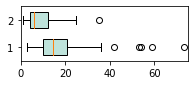

In [32]:
## Edit
plt.figure(figsize=(3,1))
fig = plt.boxplot([ df2.edit, df1.edit], widths = 0.6, patch_artist=True, vert=False)
for patch in fig['boxes']:
    patch.set_facecolor('#bee3db')
plt.xlim([0,75])
      
plt.show()